# 环境准备

In [ ]:
!pip install tensor-sensor[torch]
!pip install wandb
!pip install pytorch-lightning
!pip install pyts

In [1]:
IMAGESIZE = 32
WINDOWSIZE = IMAGESIZE
# BATCHSIZE=256
EPOCH = 1000
INPUTCHANNEL = 3

In [5]:
import sys, random, datetime, gc, json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch, torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import torchmetrics

import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
raw_normal = np.load("./drive/MyDrive/Colab Notebooks/normal_gramian_nicu_{}_{}.npy".format(IMAGESIZE, INPUTCHANNEL))
raw_sepsis = np.load("./drive/MyDrive/Colab Notebooks/sepsis_gramian_nicu_{}_{}.npy".format(IMAGESIZE, INPUTCHANNEL))

In [13]:
raw_normal = np.load("./drive/MyDrive/Colab Notebooks/normal_{}.npy".format(IMAGESIZE))
raw_sepsis = np.load("./drive/MyDrive/Colab Notebooks/sepsis_{}.npy".format(IMAGESIZE))

In [14]:
print(raw_normal.shape, raw_sepsis.shape)

(7670, 1024, 3) (1486, 1024, 3)


In [ ]:
# only for AlexNet
raw = np.concatenate([raw_normal.reshape(-1, raw_normal.shape[-1]), raw_sepsis.reshape(-1,raw_sepsis.shape[-1])])
print(raw.shape)

(7004993, 5)


In [ ]:
np.isnan(raw).sum().sum()

0

In [ ]:
# only for AlexNet
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
transformed_raw = pca.fit_transform(raw)
print(transformed_raw.shape)

(7004993, 3)


In [ ]:
# only for AlexNet
raw_normal = pca.transform(raw_normal.reshape(-1,raw_normal.shape[-1])).reshape(-1, WINDOWSIZE, 3)
raw_sepsis = pca.transform(raw_sepsis.reshape(-1,raw_sepsis.shape[-1])).reshape(-1, WINDOWSIZE, 3)

In [15]:
normal_reshaped = []
sepsis_reshaped = []

sample_index=random.sample(range(len(raw_normal)), int(len(raw_sepsis)))
raw_normal = raw_normal[sample_index]

len_total = len(sample_index)
print(len_total, len(raw_normal), len(raw_sepsis))

for i in range(len_total):
    normal_reshaped.append(raw_normal[i].reshape(IMAGESIZE, IMAGESIZE,-1).transpose(2,0,1))
    sepsis_reshaped.append(raw_sepsis[i].reshape(IMAGESIZE, IMAGESIZE,-1).transpose(2,0,1))

1486 1486 1486


In [8]:
normal_reshaped[0].shape

(3, 32, 32)

In [16]:
X = normal_reshaped+sepsis_reshaped
y = np.concatenate((np.zeros(len_total), np.ones(len_total)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=890708)

train_list = [[X_train[i], y_train[i]] for i in range(len(y_train))]
test_list = [[X_test[i], y_test[i]] for i in range(len(y_test))]

In [12]:
len(X_train)

2080

In [17]:
class MyDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def my_collate(data):
    x = np.array([d[0] for d in data])
    y = np.array([d[1] for d in data])
    # print(x.shape, y.shape)
    return torch.from_numpy(x).half(), torch.from_numpy(y).unsqueeze(1)

In [18]:
train_set = MyDataset(train_list)
test_set = MyDataset(test_list)

train_loader = DataLoader(train_set, batch_size=2048, shuffle=True, collate_fn=my_collate, drop_last=True, num_workers=4)
val_loader = DataLoader(test_set, batch_size=len(test_set), collate_fn=my_collate, num_workers=4)

In [19]:
# 建立神经网络

class NET(pl.LightningModule):
    def __init__(
        self,
        cnn1_in_channel,
        cnn1_out_channel,
        cnn1_kernel_size,
        cnn2_out_channel,
        cnn2_kernel_size,
        cnn3_out_channel,
        cnn3_kernel_size,
        fc1_output_size,
        fc2_output_size,
        dilation1,
        dilation2,
        dilation3,
        lr
    ):
        super().__init__()

        self.cnn2_out_channel = cnn2_out_channel

        self.cnn1_1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=cnn1_in_channel,
                out_channels=cnn1_out_channel,
                kernel_size=cnn1_kernel_size,
                padding=(
                    (dilation1 - 1) * (cnn1_kernel_size - 1) + cnn1_kernel_size - 1
                )
                // 2,
                dilation=dilation1,
            ),
            torch.nn.BatchNorm2d(cnn1_out_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        self.cnn1_2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=cnn1_in_channel,
                out_channels=cnn1_out_channel,
                kernel_size=cnn1_kernel_size,
                padding=(
                    (dilation2 - 1) * (cnn1_kernel_size - 1) + cnn1_kernel_size - 1
                )
                // 2,
                dilation=dilation2,
            ),
            torch.nn.BatchNorm2d(cnn1_out_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        self.cnn1_3 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=cnn1_in_channel,
                out_channels=cnn1_out_channel,
                kernel_size=cnn1_kernel_size,
                padding=(
                    (dilation3 - 1) * (cnn1_kernel_size - 1) + cnn1_kernel_size - 1
                )
                // 2,
                dilation=dilation3,
            ),
            torch.nn.BatchNorm2d(cnn1_out_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=cnn1_out_channel * 3,
                out_channels=cnn2_out_channel,
                kernel_size=cnn2_kernel_size,
                padding=(cnn2_kernel_size - 1) // 2,
                dilation=dilation1,
            ),
            torch.nn.BatchNorm2d(cnn2_out_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        # self.cnn3 = torch.nn.Sequential(
        #     torch.nn.Conv2d(
        #         in_channels=cnn2_out_channel,
        #         out_channels=cnn3_out_channel,
        #         kernel_size=cnn3_kernel_size,
        #         padding=(cnn3_kernel_size - 1) // 2,
        #         dilation=dilation1,
        #     ),
        #     torch.nn.BatchNorm2d(cnn3_out_channel),
        #     torch.nn.ReLU(),
        #     torch.nn.MaxPool2d(2),
        # )

        self.cnn_output_size = cnn2_out_channel * (IMAGESIZE // 4) ** 2
        self.fc1 = torch.nn.Linear(
            in_features=self.cnn_output_size, out_features=fc1_output_size,
        )

        self.fc2 = torch.nn.Linear(
            in_features=fc1_output_size, out_features=fc2_output_size,
        )
        self.fc3 = torch.nn.Linear(in_features=fc2_output_size, out_features=1,)
        self.relu = torch.nn.ReLU()
        self.dp = torch.nn.Dropout(0.5)
        self.sigmoid = torch.nn.Sigmoid()
        self.bn1 = torch.nn.BatchNorm1d(fc1_output_size)
        self.bn2 = torch.nn.BatchNorm1d(fc2_output_size)

        self.lr = lr

        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.valid_auc = torchmetrics.AUROC()
        self.valid_precision = torchmetrics.Precision()
        self.valid_recall = torchmetrics.Recall()
        self.valid_f1 = torchmetrics.F1()

        self.loss = torch.nn.BCEWithLogitsLoss()

        self.save_hyperparameters()

    def forward(self, x):
        out1_1 = self.cnn1_1(x.float())
        out1_2 = self.cnn1_2(x.float())
        out1_3 = self.cnn1_3(x.float())
        out = torch.cat([out1_1, out1_2, out1_3], dim=1)
        out = self.cnn2(out)
        # out = self.cnn3(out)
        out = out.reshape(-1, self.cnn_output_size)
        out = self.dp(out)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dp(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.fc3(out)
        # out = self.sigmoid(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        z_prob = self.sigmoid(z)
        z_pred = torch.round(z_prob)
        loss = self.loss(z, y)
        self.train_acc(z_pred, y.int())

        self.log("train/loss", loss, on_epoch=False, on_step=True)
        self.log("train/acc", self.train_acc, on_epoch=False, on_step=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        z = self.forward(x)
        z_prob = self.sigmoid(z)
        z_pred = torch.round(z_prob)
        loss = self.loss(z, y)
        self.valid_acc(z_pred, y.int())
        self.valid_auc(z_prob, y.int())
        self.valid_precision(z_pred, y.int())
        self.valid_recall(z_pred, y.int())
        self.valid_f1(z_pred, y.int())

        self.log("valid/loss", loss, on_epoch=True, on_step=False)
        self.log("valid/acc", self.valid_acc, on_epoch=True, on_step=False)
        self.log("valid/auc", self.valid_auc, on_epoch=True, on_step=False)
        self.log('valid/precision', self.valid_precision, on_epoch=True, on_step=False)
        self.log('valid/recall', self.valid_recall, on_epoch=True, on_step=False)
        self.log('valid/f1', self.valid_f1, on_epoch=True, on_step=False)
        return z_prob

    # def validation_epoch_end(self, validation_step_outputs):
    #     flattened_logits = torch.flatten(torch.cat(validation_step_outputs))
    #     self.logger.experiment.log(
    #         {
    #             "valid/logits": wandb.Histogram(flattened_logits.cpu()),
    #             "global_step": self.global_step,
    #         }
    #     )

    # def predict_step(self, pred_batch, batch_idx):
    #     xs, ys = pred_batch
    #     z = self.forward(xs)
    #     return z, ys

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [16]:
# Pretrained AlexNet

class NET(pl.LightningModule):
    def __init__(
        self,
        lr
    ):
        super().__init__()

        alexnet = torchvision.models.alexnet(pretrained=False)
        alexnet.classifier[6] = torch.nn.Linear(in_features=alexnet.classifier[6].in_features, out_features=1)

        self.base_model = alexnet
        self.sigmoid = torch.nn.Sigmoid()

        self.lr = lr

        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.valid_auc = torchmetrics.AUROC()
        self.valid_precision = torchmetrics.Precision()
        self.valid_recall = torchmetrics.Recall()
        self.valid_f1 = torchmetrics.F1()

        self.loss = torch.nn.BCEWithLogitsLoss()

        self.save_hyperparameters()

    def forward(self, x):
        return self.base_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        z_prob = self.sigmoid(z)
        z_pred = torch.round(z_prob)
        loss = self.loss(z, y)
        self.train_acc(z_pred, y.int())

        self.log("train/loss", loss, on_epoch=False, on_step=True)
        self.log("train/acc", self.train_acc, on_epoch=False, on_step=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        z = self.forward(x)
        z_prob = self.sigmoid(z)
        z_pred = torch.round(z_prob)
        loss = self.loss(z, y)
        self.valid_acc(z_pred, y.int())
        self.valid_auc(z_prob, y.int())
        self.valid_precision(z_pred, y.int())
        self.valid_recall(z_pred, y.int())
        self.valid_f1(z_pred, y.int())

        self.log("valid/loss", loss, on_epoch=True, on_step=False)
        self.log("valid/acc", self.valid_acc, on_epoch=True, on_step=False)
        self.log("valid/auc", self.valid_auc, on_epoch=True, on_step=False)
        self.log('valid/precision', self.valid_precision, on_epoch=True, on_step=False)
        self.log('valid/recall', self.valid_recall, on_epoch=True, on_step=False)
        self.log('valid/f1', self.valid_f1, on_epoch=True, on_step=False)
        return z_prob

    # def validation_epoch_end(self, validation_step_outputs):
    #     flattened_logits = torch.flatten(torch.cat(validation_step_outputs))
    #     self.logger.experiment.log(
    #         {
    #             "valid/logits": wandb.Histogram(flattened_logits.cpu()),
    #             "global_step": self.global_step,
    #         }
    #     )

    # def predict_step(self, pred_batch, batch_idx):
    #     xs, ys = pred_batch
    #     z = self.forward(xs)
    #     return z, ys

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [20]:
model = NET(
    cnn1_in_channel=3,
    cnn1_out_channel=8,
    cnn1_kernel_size=3,
    cnn2_out_channel=24,
    cnn2_kernel_size=3,
    cnn3_out_channel=24,
    cnn3_kernel_size=3,
    fc1_output_size=128,
    fc2_output_size=64,
    dilation1=1,
    dilation2=2,
    dilation3=4,
    lr=1e-4,
)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
# for pre-trained AlexNet
model = NET(lr=1e-4)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [21]:
wandb_logger = WandbLogger(
    name="cnn-simple-32-3",
    project="Thesis-dl1",
    tags=["cnn"],
    version="0.12",
    # save_code=True,
)

In [22]:
early_stop_callback = EarlyStopping(
    monitor='valid/loss',
    patience=10,
    mode='min',
    # min_delta=0.001,
    verbose=True,
)

checkpoint_callback = ModelCheckpoint(
    monitor='valid/loss',
    mode='min',
    # verbose=True,
    # dirpath='./drive/MyDrive/Colab Notebooks/checkpoints',
)

trainer = pl.Trainer(
    callbacks=[
        # early_stop_callback,
        # checkpoint_callback,
    ],
    gpus=-1,
    logger=wandb_logger,
    log_every_n_steps=10,
    max_epochs=300,
    deterministic=True,
    precision=16,
    default_root_dir='./drive/MyDrive/Colab Notebooks/checkpoints',
    val_check_interval=1,
    # auto_scale_batch_size=True,
)

trainer.fit(model, train_loader, val_loader)
# pred = trainer.predict(model, dataloaders=val_loader)

# model_name = 'model.onnx'
# torch.onnx.export(
#     model,
#     args=torch.randn([1, 4, 40]),
#     verbose=True,
#     f=model_name,
#     opset_version=11,
#     input_names=["input"],
#     output_names=["output"],
# )
# wandb.save(model_name)

wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: philliphu (use `wandb login --relogin` to force relogin)



   | Name            | Type              | Params
-------------------------------------------------------
0  | cnn1_1          | Sequential        | 240   
1  | cnn1_2          | Sequential        | 240   
2  | cnn1_3          | Sequential        | 240   
3  | cnn2            | Sequential        | 5.3 K 
4  | fc1             | Linear            | 196 K 
5  | fc2             | Linear            | 8.3 K 
6  | fc3             | Linear            | 65    
7  | relu            | ReLU              | 0     
8  | dp              | Dropout           | 0     
9  | sigmoid         | Sigmoid           | 0     
10 | bn1             | BatchNorm1d       | 256   
11 | bn2             | BatchNorm1d       | 128   
12 | train_acc       | Accuracy          | 0     
13 | valid_acc       | Accuracy          | 0     
14 | valid_auc       | AUROC             | 0     
15 | valid_precision | Precision         | 0     
16 | valid_recall    | Recall            | 0     
17 | valid_f1        | F1                | 

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


valid/loss,0.43264
valid/acc,0.79596
valid/auc,0.89012
valid/precision,0.73705
valid/recall,0.88095
valid/f1,0.8026
epoch,299
trainer/global_step,299
_runtime,456
_timestamp,1621564308
_step,329


valid/loss,██▇▇▆▅▄▄▅▇▇██▇▇█▇▇▇▆▆▆▇▆▅▄▄▃▄▃▃▂▂▂▂▂▁▁▁▁
valid/acc,▁▁▂▃▃▅▆▆▅▃▃▂▂▃▃▃▄▃▃▄▄▄▄▄▅▆▅▆▆▆▆▇▇▇▇▇████
valid/auc,▁▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
valid/precision,█▇█▆▅▅▄▃▂▂▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂▃▂▃▃▃▃▄▄▄▄▄▄▄▅▄
valid/recall,▁▁▂▂▃▄▆▇███████████████████████▇▇▇▇▇▇▇▇▇
valid/f1,▁▁▂▄▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
wandb.finish()

_timestamp,1621524188
train/loss,0.688
valid/loss,0.66976
trainer/global_step,101
epoch,0
_runtime,3074
valid/acc,0.57763
_step,111
train/acc,0.5625
valid/auc,0.61577


# 旧训练

In [ ]:
# old
model = NET().cuda()

vis.close('training')
vis.close('testing')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# weights = torch.FloatTensor([1,5])
criterion = torch.nn.BCEWithLogitsLoss()
testing_loss = torch.nn.BCELoss(reduction='mean')
es = EarlyStop(threshold=0.3)

EARLYSTOPEPOCH = 0
ISSTOP = False

global_batch_iter = 0
for epoch in range(EPOCH):
    batch_iter = 0
    for x,y in train_loader:
        out = model(x)
        target = torch.from_numpy(y).long().cuda()
        target = F.one_hot(target, num_classes=2).float()

        loss = criterion(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # for name, parms in model.named_parameters():	
        #     print('name:', name, 'grad_requirs:',parms.requires_grad, ' grad_value:',parms.grad)
        # sys.exit(1)
        batch_iter += 1
        global_batch_iter += 1

    # vis.line(X=torch.FloatTensor([epoch+1]), Y=torch.FloatTensor([loss.item()]), win='training', update='append')

    with torch.no_grad():
        for X, y in test_loader:
            o = model(X)
            y_true = torch.from_numpy(np.array(y))
            y_prob = F.softmax(o).double().cpu()[:,1]
            y_pred = torch.round(y_prob)
            acc = metrics.accuracy_score(y_pred, y_true)
            testing_bce = testing_loss(y_prob, y_true)
            vis.line(X=[epoch+1], Y=[[loss.item(), testing_bce]], win='training', update='append', opts=dict(title='training and testing loss', legend=['training loss', 'testing loss']))
            vis.line(X=[epoch+1], Y=[acc], win='testing', update='append', opts=dict(title='testing accuracy', legend=['testing acc']))
            if es.isStop(testing_bce):
                EARLYSTOPEPOCH = epoch+1
                ISSTOP = True
                break

    print('Train Epoch: {:0>4d}\tLoss: {:.6f}'.format(epoch+1, loss.item()))
    if ISSTOP:
        print('early stop epoch: {}'.format(EARLYSTOPEPOCH))
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The Minimum Loss has been updated to 0.6642
Train Epoch: 0001	Loss: 0.698369
The Minimum Loss has been updated to 0.6427
Train Epoch: 0002	Loss: 0.690851
The Minimum Loss has been updated to 0.6374
Train Epoch: 0003	Loss: 0.660792
The Minimum Loss has been updated to 0.6231
Train Epoch: 0004	Loss: 0.641090
Train Epoch: 0005	Loss: 0.626279
The Minimum Loss has been updated to 0.6156
Train Epoch: 0006	Loss: 0.606325
The Minimum Loss has been updated to 0.6091
Train Epoch: 0007	Loss: 0.600569
The Minimum Loss has been updated to 0.5875
Train Epoch: 0008	Loss: 0.584499
Train Epoch: 0009	Loss: 0.568686
Train Epoch: 0010	Loss: 0.557588
Train Epoch: 0011	Loss: 0.548348
Train Epoch: 0012	Loss: 0.544464
Train Epoch: 0013	Loss: 0.516428
Train Epoch: 0014	Loss: 0.506501
Train Epoch: 0015	Loss: 0.492700
Train Epoch: 0016	Loss: 0.482372
Train Epoch: 0017	Loss: 0.457131
Train Epoch: 0018	Loss: 0.446715
Train Epoch: 0019	Loss: 0.425178
Train Epoch: 0020	Loss: 0.407336
Train Epoch: 0021	Loss: 0.390214

acc:0.6604
auc:0.7073
 f1:0.6355
117 45 64 95
fpr:0.2778
fnr:0.4025
              precision    recall  f1-score   support

         0.0       0.65      0.72      0.68       162
         1.0       0.68      0.60      0.64       159

    accuracy                           0.66       321
   macro avg       0.66      0.66      0.66       321
weighted avg       0.66      0.66      0.66       321



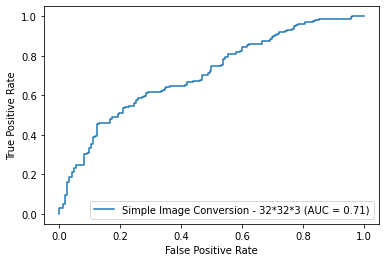

In [ ]:
results_dic = {}
# sig = torch.nn.Sigmoid()
with torch.no_grad():
    x, y = iter(test_loader).next()
    y_prob = F.softmax(model(x), dim=1).cpu().detach().numpy()
    y_pred = (y_prob[:,1] > y_prob[:, 0]).astype(np.int32)
    y_true = torch.from_numpy(np.array(y))
    # ACC
    accuracy_score = metrics.accuracy_score(y_pred, y_true)
    print('acc:{:.4f}'.format(accuracy_score))
    results_dic['GRAMIAN_{:0>3d}_{}'.format(IMAGESIZE, 'ACC')] = accuracy_score
    # AUC
    roc_auc_score = metrics.roc_auc_score(y_true, y_prob[:,1], average=None)
    print('auc:{:.4f}'.format(roc_auc_score))
    results_dic['GRAMIAN_{:0>3d}_{}'.format(IMAGESIZE, 'AUC')] = roc_auc_score
    # F1
    f1_score = metrics.f1_score(y_true, y_pred)
    print(' f1:{:.4f}'.format(f1_score))
    results_dic['GRAMIAN_{:0>3d}_{}'.format(IMAGESIZE, '_F1')] = f1_score
    # CONFUSION MATRIX
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    print(tn, fp, fn, tp)
    print('fpr:{:.4f}'.format(fp/(fp+tn)))
    print('fnr:{:.4f}'.format(fn/(fn+tp)))
    results_dic['GRAMIAN_{:0>3d}_{}'.format(IMAGESIZE, 'FPR')] = fp/(fp+tn)
    results_dic['GRAMIAN_{:0>3d}_{}'.format(IMAGESIZE, 'FNR')] = fn/(fn+tp)
    # Classificatin Report
    print(metrics.classification_report(y_true, y_pred))
    # ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    results_dic['GRAMIAN_{:0>3d}_{}'.format(IMAGESIZE, 'ROC')] = roc_auc
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Simple Image Conversion - 32*32*3')
    display.plot()
    plt.show()

with open('gramian_result.json', 'w') as f:
    json.dump(results_dic, f)